In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import all libraries
import numpy as np
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from pathlib import Path
from io import BytesIO

from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import games in csv
csv_path = r"drive/MyDrive/DL/filtered_games_20_players.csv"

# Data loading
data = pd.read_csv(csv_path) # loading into dataframe


/tmp/ipython-input-490902306.py:30: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path) # loading into dataframe


In [5]:
# Here we train an RNN (with LSTM) predicting which player from the pool
# has participated in the game based on only the played moves.

NEW_LIST_OF_PLAYERS_MANUAL = [
    'ArasanX',
    'MassterofMayhem',
    'JelenaZ',
    'lestri',
    'doreality',
    'therealYardbird',
    'Chesssknock',
    'No_signs_of_V',
    'Recobachess',
    'drawingchest',
    'kasparik_garik',
    'ChainsOfFantasia',
    'Consent_to_treatment',
    'Alexandr_KhleBovich',
    'unknown-maestro_2450',
    'gefuehlter_FM',
    'gmmitkov',
    'positionaloldman',
    "Carlsen, Magnus",
    "Nakamura, Hikaru"]

# Initialize batch size, needs to be big here for faster
# simulations on the laptop, and smaller when using LUMI
BATCH_SIZE = 32

# Define the lngth of the games (small for laptop and
# big when using LUMI)
GAME_LENGTH = 100

# Step size / Learning rate for the Adam optimizer
LEARNING_RATE = 2e-3

# Iterations / Epochs
EPOCHS = 50

# we set names (coloumns) as strings
data["white_name"] = data["white_name"].astype(str)
data["black_name"] = data["black_name"].astype(str)

def player_match(name : str):
    # Return player name if in sub-string
    lowered = name.lower()
    for player in NEW_LIST_OF_PLAYERS_MANUAL:
        if player.lower() == lowered:
            return player
    return None

# Now determining player of each game
w = data["white_name"].apply(player_match)
b = data["black_name"].apply(player_match)
data["PlayerLabel"] = w.fillna(b) # if not white go back to black

# Remove all other games
data = data.dropna(subset=["PlayerLabel"]).reset_index(drop=True)

# now we map locally
encodep = dict(zip(NEW_LIST_OF_PLAYERS_MANUAL, range(len(NEW_LIST_OF_PLAYERS_MANUAL))))
decodep = {m: l for l, m in encodep.items()}


In [6]:
# --- TOKENIZATION --- (from used steps/moves)

# we make a temperory split for training tokenization
dat_temp = data
l = len(dat_temp)

# Stratification is not necessary here, as this random split is discarded later. It is only used for creating the tokenization vocabulary.
traindata, _, _ = random_split(
    range(l),
    [int(l*0.8), int(l*0.1), l - int(l*0.8) - int(l*0.1)], # test data
    generator=torch.Generator().manual_seed(123) # seed
)

# Using cleaner to take unwanted things out
cleaner = str.maketrans({"[": "", "]": "", "'": "", ",": ""})
all_step = [ # flatten moves from games
    k
    for s in data.loc[traindata.indices, "list_of_moves"]
    for k in s.translate(cleaner).split()
]
# count frequency of moves
frequency = Counter(all_step)

# keeping it simple (just anything we dont know)
dir = {"<PAD>": 0, "<UNK>": 1}
# Assign id
dir.update({n: len(dir) + i for i, n in enumerate(frequency)})





In [8]:
# --- DATA PREPARATION ---
TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
MANUAL_SEED = 123  # not used for now

def step_encode(step): # convert raw mos into tokens
    # This pads using zeroes and trunctaes with game-lenth
    cleaned = step.translate(str.maketrans({"[": "", "]": "", "'": "", ",": ""}))
    tokening = cleaned.split()
    # use ids
    # use UNK(1) when it is unknown
    vector = list(map(lambda i_token: dir.get(i_token, 1), tokening[: GAME_LENGTH]))
    pad = np.zeros(GAME_LENGTH - len(vector), dtype=int).tolist()
    vector = vector + pad
    return vector

class GameSequence(Dataset): # wrapping dataset
    def __init__(object, wind): # store frame
        object.win = wind
        # convert names inot int labeling for class
        object.labels = wind["PlayerLabel"].map(encodep).to_list()
        object.moves  = wind["list_of_moves"].to_list() # save for encoding

    def __len__(object): # pytorch standard
        length = object.win.__len__() # nr of samples
        return length

    def __getitem__(object, m): # get training from index
        # id's of tokens
        x = torch.tensor(step_encode(object.moves[m]), dtype=torch.long)
        # player
        y = torch.tensor(object.labels[m], dtype=torch.long)
        return x, y

# Now we spilt the data into train, validation and
# test data as learnt in the lectures

gs_data = GameSequence(data)
labels = gs_data.labels

train_indices, val_test_indices = train_test_split(
    range(len(labels)),
    test_size=VALIDATION_SPLIT + TEST_SPLIT,
    stratify=labels,  # this makes sure that each player occurs same amount along all 3 datasets
)

validation_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT),  # is equal to how much should actually be used for TESTING
    stratify=[labels[i] for i in val_test_indices]
)

train_data = Subset(gs_data, train_indices)
validation_data = Subset(gs_data, validation_indices)
test_data = Subset(gs_data, test_indices)

# Suffle only train, not the others
TRAIN_DATALOADER = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
VALIDATION_DATALOADER = DataLoader(validation_data, batch_size = BATCH_SIZE)
TEST_DATALOADER = DataLoader(test_data, batch_size = BATCH_SIZE)

# Cross Entropy loss (ideal and simple for classification tasks)
loss_fn = nn.CrossEntropyLoss()

In [9]:
# --- THE RNN MODEL ---

class RecurrentNN(nn.Module):
    def __init__(self, dir, dim_embedded, dim_hidden_layer, dim_out):
        super(RecurrentNN, self).__init__() # initilaze pytorch nn.module

        # lookup table for the tokens
        self.table = nn.Embedding( # embedding for tokens
            num_embeddings=dir,
            embedding_dim=dim_embedded,  # size of embeddings
            padding_idx=0  # telling torch 0's are padding, not actual moves
        )

        # Core
        self.core = nn.LSTM( # lstm core
            input_size=dim_embedded, # use embedding vector
            # hidden dimension
            hidden_size=dim_hidden_layer,
            # 2 layers for a bit better results
            num_layers=2,
            batch_first=True,
            bidirectional=True, # backward and forward
            dropout=0.25 # minimizing overfitting (drop 25% units randomly)
            # For 2 layers it is ignored but for layers >= 3 (for later) it is good to have
        )

        # projection block outputting
        self.proj = nn.Sequential( # classifier part
            nn.Linear(2*dim_hidden_layer, 2*dim_hidden_layer),
            nn.ReLU(),
            nn.Dropout(0.2), # same like before (being less dependent on single neurons)
            nn.Linear(2 * dim_hidden_layer, dim_out) # since bidirectional
        )

    def forward(self, x): # input flow
        x = self.table(x) # embedding tokens
        _,(state,_) = self.core(x) # running sequence

        # now we have the Last backward and forward states (hidden)
        fowardstate  = state[-2] # for 2 layers
        backwardstate = state[-1]

        # here we have a single vector concatenation
        vector = torch.cat([fowardstate, backwardstate], dim=1)

        return self.proj(vector)

# LSTM hidden dimension
HIDDEN_LAYER_DIM = 128

# Embedding dimension
EMBEDDED_LAYER_DIM = 128

model = RecurrentNN( # Building model
    dir=len(dir),
    dim_embedded=EMBEDDED_LAYER_DIM,
    dim_hidden_layer=HIDDEN_LAYER_DIM,
    dim_out=len(encodep)
).to(device)

# For RNN's, ADAM is the way to go.
optimizer = torch.optim.Adam(params=list(model.parameters()), lr=LEARNING_RATE)


In [10]:
def train_validate(train_loader: DataLoader,
                   validation_loader: DataLoader,
                   model: nn.Module,
                   optimizer,
                   scheduler,
                   device: torch.device):
    model.train() # training mode activation before updating gradients

    # Initialize variables
    batch_losses_train = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_train = []
    true_labels_train = []

    for xbatch, ybatch in tqdm(train_loader, colour='green'): # iterating batches
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # reset from last batch
        optimizer.zero_grad()
        output = model(xbatch)
        loss = loss_fn(output, ybatch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(output, dim=1)

        batch_losses_train.append(loss.item())
        pred_labels_train.append(preds)
        true_labels_train.append(ybatch)

    # Format useful lists for calculation of metrics
    pred_labels_train = torch.cat(pred_labels_train, dim=0).detach().cpu().numpy().flatten()
    true_labels_train = torch.cat(true_labels_train, dim=0).detach().cpu().numpy().flatten()

    avg_train_loss = np.mean(batch_losses_train)

    # VALIDATE
    model.eval()

    # Initialize variables
    batch_losses_val = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_val = []
    true_labels_val = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in validation_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_val.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_val.append(preds)
            true_labels_val.append(ybatch)

    avg_val_loss = np.mean(batch_losses_val)

    # Format useful lists for calculation of metrics
    pred_labels_val = torch.cat(pred_labels_val, dim=0).cpu().detach().numpy().flatten()
    true_labels_val = torch.cat(true_labels_val, dim=0).cpu().detach().numpy().flatten()

    return avg_train_loss, avg_val_loss, \
        (pred_labels_train, true_labels_train), \
        (pred_labels_val, true_labels_val)

def test(test_loader: DataLoader,
         model: nn.Module,
         device: torch.device):
    # Now we test on the test data at the end

    model.eval()

    # Initialize variables
    batch_losses_test = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_test = []
    true_labels_test = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in test_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_test.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_test.append(preds)
            true_labels_test.append(ybatch)

    avg_test_loss = np.mean(batch_losses_test)

    # Format useful lists for calculation of metrics
    pred_labels_test = torch.cat(pred_labels_test, dim=0).cpu().detach().numpy().flatten()
    true_labels_test = torch.cat(true_labels_test, dim=0).cpu().detach().numpy().flatten()

    return avg_test_loss, (pred_labels_test, true_labels_test)


In [11]:

'''
To calculate different kind of metrics based on:
- Average (train/validation/test) loss
- Predicted labels for training/validation/test
- True labels for training/validation/test

Calculates:
- Classification metrics
    - F1 scores (macro, weighted, per-class)
    - Confusion matrix (and prints)
    - Classification report
    - Balanced accuracy score
- Regression metrics
    - Mean absolute error
    - (root) mean squared error
    - R2 score

Shows:
    - Confusion matrix
    - Predicted vs True regression plot
'''
def calculateMetrics(avg_loss : np.ndarray, predicted_labels : np.ndarray, true_labels : np.ndarray):
    # --- CLASSIFICATION ---
    '''
    Macro F1 = The average f1 score over all classes, treating each class equally.
    This score becomes more relevant when some players have very few games.
    '''
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    '''
    Weighted F1 = Same as Macro F1, but is weighted by class frequency. It doesn't punish too hard for players with few games.
    '''
    weighted_f1 = f1_score(true_labels, predicted_labels, average="weighted")

    '''
    Per-class F1 scores, this doesn't average over all classes and shows how different players compare
    Is not printed, because classification_report already does it in a nice way, but wanted to include here
    Because it shows the relevance.
    '''
    per_class_f1 = f1_score(true_labels, predicted_labels, average=None)

    '''
    A full on confusion matrix of shape NxN.
    '''
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    '''
    Balanced accuracy = Each class contributes equally to the accuracy, better than the usual way of calculating accuracy: correct / total
    '''
    bal_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

    print(
        f"--- CLASSIFICATION METRICS --- \n"
        f"F1 scores: [Macro={macro_f1:.3f}, Weighted={weighted_f1:.3f}] \n"
        f"Balanced Accuracy = {bal_accuracy:.3f}"
        f"Average loss = {avg_loss:.5f}")

    report = classification_report(true_labels, predicted_labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(tabulate(df.round(3), headers='keys', tablefmt="pretty"))

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=False, cmap="Blues")
    plt.title("Confusion matrix")
    plt.show()


Beginning training... using cuda device


100%|██████████| 9305/9305 [01:42<00:00, 90.37it/s]


Epoch 0, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.466, Weighted=0.497] 
Balanced Accuracy = 0.480Average loss = 1.63884
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.538   | 0.638  |  0.584   | 21737.0  |
|      1       |   0.511   | 0.659  |  0.576   | 20623.0  |
|      2       |   0.496   | 0.538  |  0.516   | 19242.0  |
|      3       |   0.677   | 0.836  |  0.748   | 18354.0  |
|      4       |   0.339   | 0.228  |  0.273   | 17338.0  |
|      5       |   0.566   | 0.626  |  0.594   | 17155.0  |
|      6       |   0.549   | 0.642  |  0.592   | 16814.0  |
|      7       |   0.602   | 0.766  |  0.675   | 16466.0  |
|      8       |   0.588   | 0.695  |  0.637   | 15886.0  |
|      9       |   0.277   | 0.136  |  0.182   | 14553.0  |
|      10      |   0.452   | 0.393  |   0.42   | 14371.0  |
|      11  

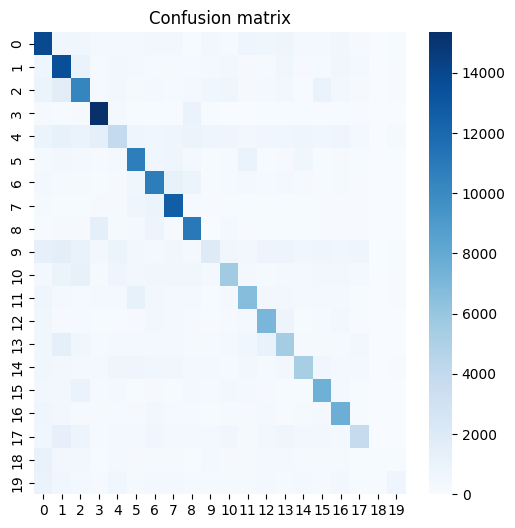

Epoch 0, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.530, Weighted=0.565] 
Balanced Accuracy = 0.546Average loss = 1.41350
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.597   |  0.72  |  0.653   | 2717.0  |
|      1       |   0.622   |  0.73  |  0.672   | 2578.0  |
|      2       |   0.593   | 0.585  |  0.589   | 2405.0  |
|      3       |   0.749   | 0.849  |  0.796   | 2294.0  |
|      4       |   0.381   | 0.348  |  0.364   | 2167.0  |
|      5       |   0.66    | 0.691  |  0.675   | 2144.0  |
|      6       |   0.58    | 0.715  |  0.641   | 2101.0  |
|      7       |   0.701   | 0.823  |  0.757   | 2058.0  |
|      8       |   0.642   | 0.789  |  0.708   | 1985.0  |
|      9       |   0.385   | 0.165  |  0.231   | 1819.0  |
|      10      |   0.548   | 0.461  |  0.501   | 1797.0  |
|      11      |   0.59

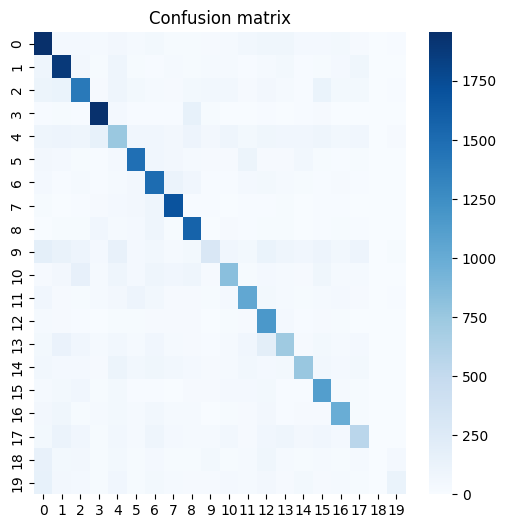

100%|██████████| 9305/9305 [01:44<00:00, 89.08it/s]


Epoch 1, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.530, Weighted=0.563] 
Balanced Accuracy = 0.542Average loss = 1.43386
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.626   | 0.705  |  0.663   | 21737.0  |
|      1       |   0.596   | 0.722  |  0.653   | 20623.0  |
|      2       |   0.564   | 0.609  |  0.586   | 19242.0  |
|      3       |   0.73    | 0.865  |  0.791   | 18354.0  |
|      4       |   0.39    | 0.296  |  0.337   | 17338.0  |
|      5       |   0.646   | 0.707  |  0.675   | 17155.0  |
|      6       |   0.603   | 0.685  |  0.642   | 16814.0  |
|      7       |   0.687   | 0.821  |  0.748   | 16466.0  |
|      8       |   0.653   |  0.75  |  0.698   | 15886.0  |
|      9       |   0.324   | 0.205  |  0.251   | 14553.0  |
|      10      |   0.525   | 0.476  |   0.5    | 14371.0  |
|      11  

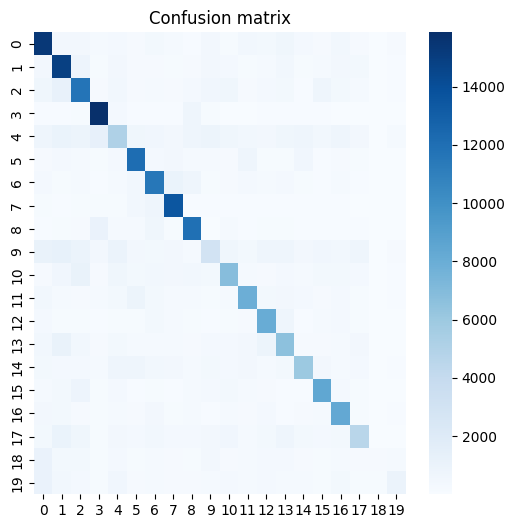

Epoch 1, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.549, Weighted=0.582] 
Balanced Accuracy = 0.562Average loss = 1.36400
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.633   | 0.722  |  0.675   | 2717.0  |
|      1       |   0.634   | 0.756  |  0.689   | 2578.0  |
|      2       |   0.632   | 0.589  |   0.61   | 2405.0  |
|      3       |   0.722   | 0.888  |  0.796   | 2294.0  |
|      4       |   0.462   | 0.299  |  0.363   | 2167.0  |
|      5       |   0.675   | 0.729  |  0.701   | 2144.0  |
|      6       |   0.551   | 0.759  |  0.638   | 2101.0  |
|      7       |    0.7    |  0.82  |  0.755   | 2058.0  |
|      8       |   0.705   | 0.736  |   0.72   | 1985.0  |
|      9       |   0.345   | 0.207  |  0.259   | 1819.0  |
|      10      |   0.544   | 0.525  |  0.534   | 1797.0  |
|      11      |   0.60

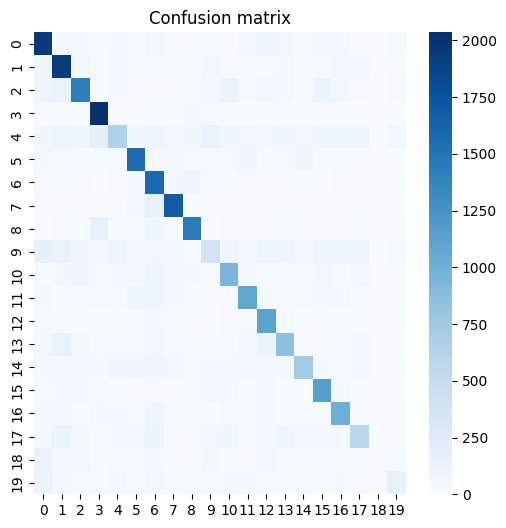

100%|██████████| 9305/9305 [01:44<00:00, 88.80it/s]


Epoch 2, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.542, Weighted=0.575] 
Balanced Accuracy = 0.553Average loss = 1.39528
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.645   | 0.722  |  0.681   | 21737.0  |
|      1       |   0.618   | 0.732  |  0.671   | 20623.0  |
|      2       |   0.581   | 0.623  |  0.601   | 19242.0  |
|      3       |   0.739   |  0.87  |  0.799   | 18354.0  |
|      4       |   0.401   | 0.315  |  0.352   | 17338.0  |
|      5       |   0.657   | 0.716  |  0.685   | 17155.0  |
|      6       |   0.61    | 0.686  |  0.646   | 16814.0  |
|      7       |   0.692   | 0.824  |  0.752   | 16466.0  |
|      8       |   0.662   | 0.757  |  0.707   | 15886.0  |
|      9       |   0.329   |  0.22  |  0.264   | 14553.0  |
|      10      |   0.539   | 0.492  |  0.514   | 14371.0  |
|      11  

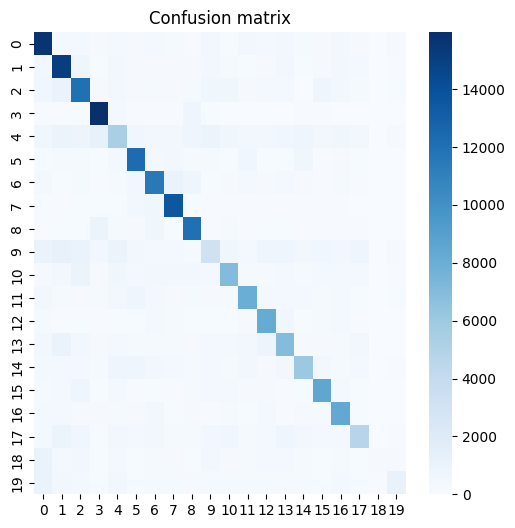

Epoch 2, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.556, Weighted=0.589] 
Balanced Accuracy = 0.569Average loss = 1.34498
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.627   | 0.762  |  0.688   | 2717.0  |
|      1       |   0.686   | 0.724  |  0.705   | 2578.0  |
|      2       |   0.611   | 0.601  |  0.606   | 2405.0  |
|      3       |   0.739   | 0.862  |  0.796   | 2294.0  |
|      4       |   0.443   | 0.276  |   0.34   | 2167.0  |
|      5       |   0.712   | 0.716  |  0.714   | 2144.0  |
|      6       |   0.623   | 0.684  |  0.652   | 2101.0  |
|      7       |   0.68    | 0.877  |  0.766   | 2058.0  |
|      8       |   0.671   | 0.801  |   0.73   | 1985.0  |
|      9       |   0.337   | 0.217  |  0.264   | 1819.0  |
|      10      |   0.574   | 0.511  |   0.54   | 1797.0  |
|      11      |   0.58

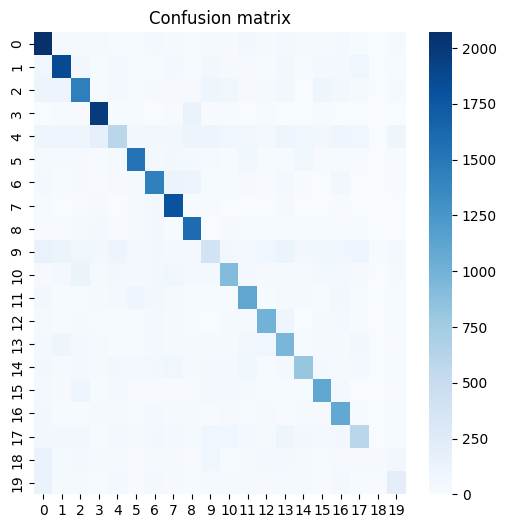

 32%|███▏      | 3024/9305 [00:35<01:14, 84.42it/s]


KeyboardInterrupt: 

In [12]:
# --- TRAINING, VALIDATION ---
train_losses, val_losses = [], []

# EARLY STOPPING
early_stop_counter = 0  # do not change
early_stop_best_loss = torch.inf
early_stop_best_model_state = None
PATIENCE = 5  # after how many epochs of no decrease in loss should we stop
DELTA = 1e-3  # if the loss decreases with maximum this delta, do not reset the counter

print(f"Beginning training... using {device} device")

for iEpoch in range(EPOCHS):
    t_loss, v_loss, (pltrain, tltrain), (plval, tlval)\
      = train_validate(train_loader=TRAIN_DATALOADER,
                       validation_loader=VALIDATION_DATALOADER,
                       model=model,
                       optimizer=optimizer,
                       scheduler=None,
                       device=device)

    print(f"Epoch {iEpoch}, training metrics:")
    calculateMetrics(t_loss, pltrain, tltrain)

    print(f"Epoch {iEpoch}, validation metrics:")
    calculateMetrics(v_loss, plval, tlval)

    # -- EARLY STOPPING CHECK --
    if v_loss < early_stop_best_loss - DELTA:
        # A better loss was found, so reset counter and save model state
        early_stop_best_loss = v_loss
        early_stop_counter = 0
        # Save the best model so we can restore it later and get the best model performance to use the test data for.
        early_stop_best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping...")

            # Restore the best model which was saved earlier.
            model.load_state_dict(early_stop_best_model_state)
            break

# --- TESTING ---
avg_test_loss = test(test_loader=TEST_DATALOADER,
                     model=model,
                     loss_fn=loss_fn,
                     device=device)
print(f"Epoch {iEpoch}, testing metrics:")
calculateMetrics(t_loss, pltrain, tltrain)